## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

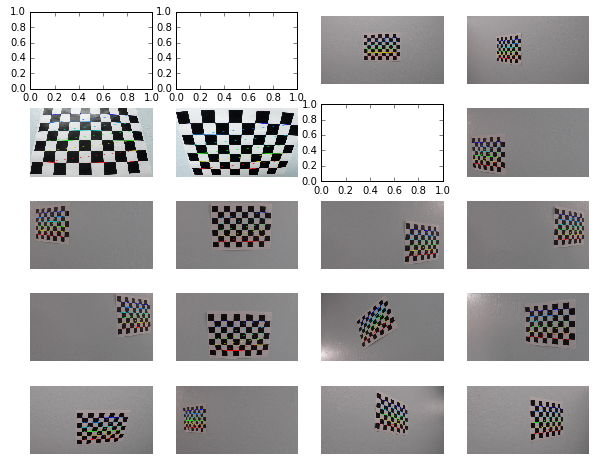

In [29]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axes = plt.subplots(5, 4, figsize=(10, 8))

# Step through the list and search for chessboard corners
for ax, fname in zip(axes.flat, images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        ax.axis('off')
        ax.imshow(img)

cv2.destroyAllWindows()

## Undirsorting images
Display the undistortion result on the examples of chessboard and real-world images and saving the undistortion parameters for future use:
* Camera Matrix
* Distortion coefficient

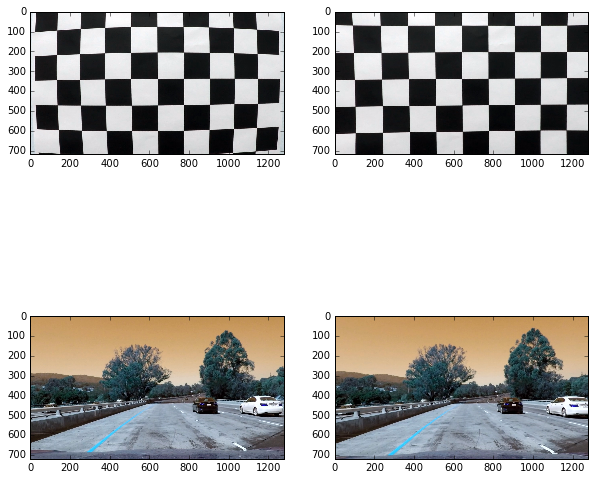

In [45]:
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

real_img = cv2.imread('./test_images/test1.jpg')
real_dst = cv2.undistort(real_img, mtx, dist, None, mtx)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, img in zip(axes.flat, [img, dst, real_img, real_dst]):
    ax.imshow(img)
    
pickle.dump(
    {
        'mtx': mtx,
        'dist': dist
    }, open('./calibration.p', 'wb')
)

## Transform perspective

In [226]:
def region_of_interest_coords(shape):
    width, height = shape[1], shape[0]
    
    vertical_mark = 0.7
    top, bottom, trapezoid_height = vertical_mark * height, height, (1 - vertical_mark) * height
    
    padding = 0.06
    bottom_left, bottom_right = padding * width, (1 - padding) * width
    
    trapezoid_ratio = 0.27
    trapezoid_length = bottom_right - bottom_left
    top_length = trapezoid_length * trapezoid_ratio
    trapezoid_offset = (trapezoid_length - top_length) / 2
    top_left, top_right = bottom_left + trapezoid_offset, bottom_right - trapezoid_offset
    
    trapezoid_coords = np.float32([
        [top_left, top], [top_right, top],
        [bottom_right, bottom], [bottom_left, bottom]
    ])
    
    return trapezoid_coords

In [227]:
def dst_coords(shape):
    width, height = shape[1], shape[0]
    offset = 0
    
    return np.float32([
        [offset, 0], [width - offset, 0],
        [width - offset, height], [offset, height] 
    ])

In [228]:
def draw_lines(img, coords):
    lines = zip(
        coords,
        np.insert(coords[:-1], 0, coords[-1], axis=0)
    )
        
    for x, y in lines:
        x = tuple(x)
        y = tuple(y)
        cv2.line(img, x, y, [255, 0, 0], 3)
        
    return img

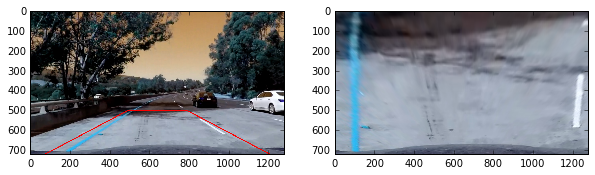

In [234]:
calibration_parameters = pickle.load( open('./calibration.p', 'rb' ) )
mtx = calibration_parameters['mtx']
dist = calibration_parameters['dist']

lanes_image = cv2.imread('./test_images/test5.jpg')
undistorted = cv2.undistort(lanes_image, mtx, dist, None, mtx)
gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)

src = region_of_interest_coords(undistorted.shape)
dst = dst_coords(undistorted.shape)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(
    undistorted, M, 
    (undistorted.shape[1], undistorted.shape[0])
)

undistorted_lines = draw_lines(undistorted, src)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for ax, img in zip(axes.flat, [undistorted_lines, warped]):
    ax.imshow(img)

##Color transformation

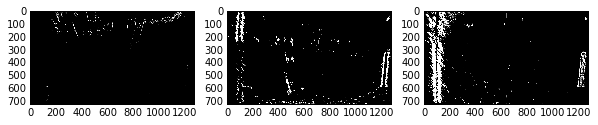

In [263]:
lanes_image = cv2.imread('./test_images/test5.jpg')

hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
H = hls[:, :, 0]
L = hls[:, :, 1]
S = hls[:, :, 2]

def treshold(img, thresh):
    thresh = (15, 100)
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
for ax, color in zip(axes.flat, [H, L, S]):
    color = np.absolute(cv2.Sobel(color, cv2.CV_64F, 1, 0, ksize=3))
    color = treshold(color, (15, 100))
    ax.imshow(color, cmap = 'gray')